In [1]:
from __future__ import print_function
%matplotlib inline

import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import random
from random import shuffle
import datetime
import csv
import keras
import os

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Data Loading

In [26]:
batch_size = 64
epochs = 400  
latent_dim = 10
num_samples = 45133

# This flag should be set to 1 for the classification style training
# Classification based task is when the network is expected to output
# 's' for the input 'apple' and 'es' for 'torch'.
# When the classfication flag is set to 0 then the network is expected to 
# output 'apples' for input 'apple' and 'torches' for input 'torch'. 
classification_flag = 1

# Path to the data txt file on disk.
data_path = './all_data.csv'

In [381]:
input_texts = []
target_texts = []

In [382]:
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [383]:
train_input = []
train_output = []

In [377]:
train_file = 'train.csv'
if classification_flag:
    train_file = 'train_ending.csv'

with open(train_file, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        train_input.append(row[0])
        train_output.append(row[1]) # replace with row[1][1:-1] if you don't want \t and \n around the word
        
        

In [384]:
test_input = []
test_output = []
test_file = 'test.csv'
if classification_flag:
    test_file = 'test_ending.csv'
with open(test_file, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        test_input.append(row[0])
        test_output.append(row[1]) # replace with row[1][1:-1] if you don't want \t and \n around the word

In [392]:
input_texts_glob = train_input + test_input
target_texts_glob = train_output + test_output

In [395]:
target_texts_glob

['\ties\n',
 '\tes\n',
 '\ties\n',
 '\ties\n',
 '\ts\n',
 '\ts\n',
 '\ts\n',
 '\ties\n',
 '\tes\n',
 '\ts\n',
 '\tes\n',
 '\ties\n',
 '\ts\n',
 '\ts\n',
 '\ties\n',
 '\ties\n',
 '\ties\n',
 '\ts\n',
 '\ties\n',
 '\tes\n',
 '\ties\n',
 '\ties\n',
 '\ts\n',
 '\ts\n',
 '\ts\n',
 '\tes\n',
 '\ties\n',
 '\tes\n',
 '\ties\n',
 '\ts\n',
 '\tes\n',
 '\ts\n',
 '\ties\n',
 '\ties\n',
 '\tes\n',
 '\ts\n',
 '\tes\n',
 '\ties\n',
 '\ties\n',
 '\tes\n',
 '\ts\n',
 '\ts\n',
 '\ties\n',
 '\tes\n',
 '\ts\n',
 '\tes\n',
 '\tes\n',
 '\tes\n',
 '\ties\n',
 '\tes\n',
 '\ties\n',
 '\ts\n',
 '\tes\n',
 '\tes\n',
 '\tes\n',
 '\ties\n',
 '\tes\n',
 '\t\n',
 '\tes\n',
 '\ts\n',
 '\t\n',
 '\tes\n',
 '\tes\n',
 '\ts\n',
 '\ties\n',
 '\ties\n',
 '\ts\n',
 '\ts\n',
 '\ts\n',
 '\tes\n',
 '\tes\n',
 '\t\n',
 '\t\n',
 '\tes\n',
 '\t\n',
 '\tes\n',
 '\ties\n',
 '\tes\n',
 '\ts\n',
 '\ties\n',
 '\ties\n',
 '\ties\n',
 '\ts\n',
 '\ties\n',
 '\ts\n',
 '\tes\n',
 '\tes\n',
 '\tes\n',
 '\ties\n',
 '\tes\n',
 '\ts\n',
 '\tes

In [393]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts_glob])
max_decoder_seq_length = max([len(txt) for txt in target_texts_glob])

In [394]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 1100
Number of unique input tokens: 26
Number of unique output tokens: 28
Max sequence length for inputs: 21
Max sequence length for outputs: 5


In [456]:
s_ending_h = []
es_ending_h = []
ies_ending_h = []
others_h = []
s_ending_c = []
es_ending_c = []
ies_ending_c = []
others_c = []
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
#     print("Inside decode_sequence: ", states_value[0].shape, states_value[1].shape)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        states_value = [h, c]

    return decoded_sentence, states_value

latent_dim = 5

encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))


decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
if classification_flag:
    model.load_weights('./final_ending_models/rmsprop_model_500_' + str(latent_dim) + '.h5')
else:
    model.load_weights('./final_models/rmsprop_model_500_' + str(latent_dim) + '.h5')

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
#     print(str(datetime.datetime.now()), "Training with ", latent_dim, " latent dimensions")

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())
out = 0 
for idx in range(len(input_texts_glob)):
    if idx % 100 == 0:
        print(idx)
    input_token_index = dict(
        [(char, i) for i, char in enumerate(input_characters)])
    target_token_index = dict(
        [(char, i) for i, char in enumerate(target_characters)])
    word = input_texts_glob[idx]
    if len(word) <= 4:
        out += 1
        continue
    input_texts = []
    for i in range(1, len(word)+1):
        input_texts.append(word[0:i])

    target_texts = [''] * len(word)
    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
        dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            encoder_input_data[i, t, input_token_index[char]] = 1.
        for t, char in enumerate(target_text):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, target_token_index[char]] = 1.
            if t > 0:
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.
  
    delta = 0
    correct = 0
    encoding_vectors = []
    for seq_index in range(len(input_texts)):
        input_seq = encoder_input_data[seq_index: seq_index+ 1]
        decoded_sentence, encoding_vec = decode_sequence(input_seq)
        
        encoding_vectors.append(np.array(encoding_vec))
    
    encoding_vectors = np.array(encoding_vectors)
    encoding_vectors = encoding_vectors.reshape((len(word), 2, latent_dim))

    states_h = np.array(encoding_vectors[-5:, 0].T)
#     print(states_h.shape)
    
    states_c = np.array(encoding_vectors[-5:, 1].T)
    if target_texts_glob[idx] == '\ts\n':
        s_ending_h.append(states_h)
        s_ending_c.append(states_c)
#         print(np.array(s_ending_h).shape)
    elif target_texts_glob[idx] == '\tes\n':
        es_ending_h.append(states_h)
        es_ending_c.append(states_c)
    elif target_texts_glob[idx] == '\ties\n':
        ies_ending_h.append(states_h)
        ies_ending_c.append(states_c)
    else:
        others_h.append(states_h)
        others_c.append(states_c)

0
100
200
300
400
500
600
700
800
900
1000


In [518]:
s_ending_h = np.array(s_ending_h)
es_ending_h = np.array(es_ending_h)
ies_ending_h = np.array(ies_ending_h)
others_h = np.array(others_h)
s_ending_c = np.array(s_ending_c)
es_ending_c = np.array(es_ending_c)
ies_ending_c = np.array(ies_ending_c)
others_c = np.array(others_c)


(324, 5, 5)

In [525]:
mean_s_ending_h = np.mean(s_ending_h, axis=0)
mean_es_ending_h = np.mean(es_ending_h, axis=0)
mean_ies_ending_h = np.mean(ies_ending_h, axis=0)
mean_others_h = np.mean(others_h, axis=0)
mean_s_ending_c = np.mean(s_ending_c, axis=0)
mean_es_ending_c = np.mean(es_ending_c, axis=0)
mean_ies_ending_c = np.mean(ies_ending_c, axis=0)
mean_others_c = np.mean(others_c, axis=0)
mean_c = np.mean(np.vstack((s_ending_c, es_ending_c, ies_ending_c, others_c)), axis=0)
mean_h = np.mean(np.vstack((s_ending_h, es_ending_h, ies_ending_h, others_h)), axis=0)

In [526]:
var_s_ending_h = np.var(s_ending_h, axis=0)
var_es_ending_h = np.var(es_ending_h, axis=0)
var_ies_ending_h = np.var(ies_ending_h, axis=0)
var_others_h = np.var(others_h, axis=0)
var_s_ending_c = np.var(s_ending_c, axis=0)
var_es_ending_c = np.var(es_ending_c, axis=0)
var_ies_ending_c = np.var(ies_ending_c, axis=0)
var_others_c = np.var(others_c, axis=0)
var_c = np.var(np.vstack((s_ending_c, es_ending_c, ies_ending_c, others_c)), axis=0)
var_h = np.var(np.vstack((s_ending_h, es_ending_h, ies_ending_h, others_h)), axis=0)

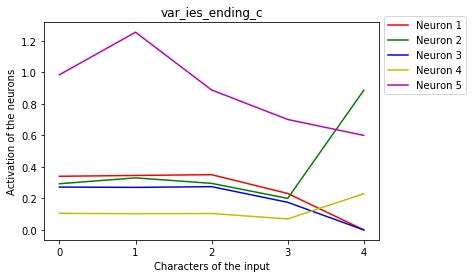

In [486]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')

for i in range(latent_dim):
    plt.plot(range(5), var_ies_ending_c[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('var_ies_ending_c')
plt.legend(bbox_to_anchor=(1.275, 1.05))


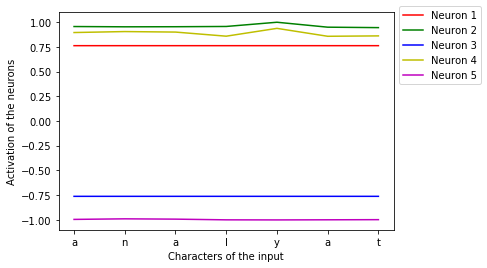

In [374]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)), characters)
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')

for i in range(latent_dim):
    plt.plot(range(len(word)), states_h[i, :], colors[i], label='Neuron '+ str(i+1))

plt.legend(bbox_to_anchor=(1.0, 1.05))


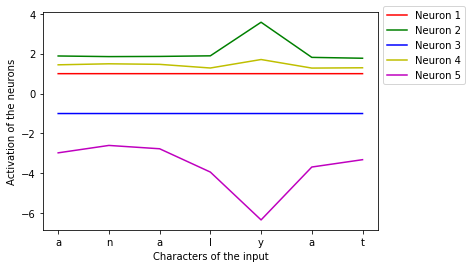

In [375]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)), characters)
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')

for i in range(latent_dim):
    plt.plot(range(len(word)), states_c[i, :], colors[i], label='Neuron '+ str(i+1))

plt.legend(bbox_to_anchor=(1, 1.05))


In [514]:
mean_c

NameError: name 'mean_c' is not defined

# Means in cell states

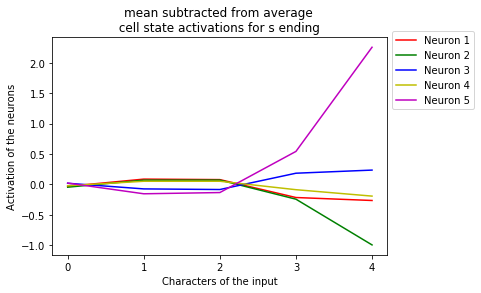

In [545]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')
temp = mean_s_ending_c - mean_c
for i in range(latent_dim):
    plt.plot(range(5), temp[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('mean subtracted from average \n cell state activations for s ending ')
plt.legend(bbox_to_anchor=(1.275, 1.05))

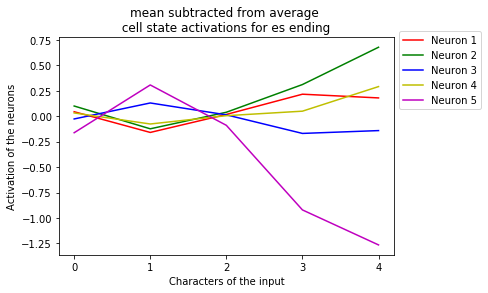

In [539]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')
temp = mean_es_ending_c - mean_c

for i in range(latent_dim):
    plt.plot(range(5), temp[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('mean subtracted from average \n cell state activations for es ending ')
plt.legend(bbox_to_anchor=(1.275, 1.05))

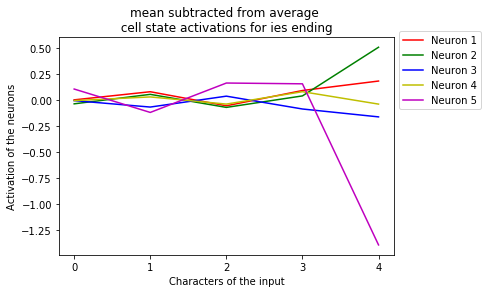

In [540]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')
temp = mean_ies_ending_c - mean_c

for i in range(latent_dim):
    plt.plot(range(5), temp[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('mean subtracted from average \n cell state activations for ies ending ')
plt.legend(bbox_to_anchor=(1.275, 1.05))

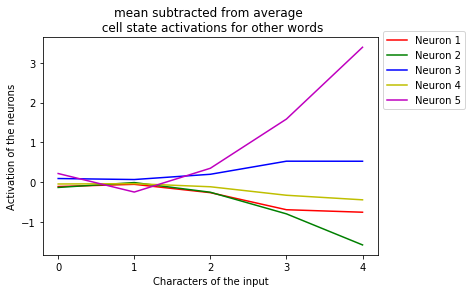

In [541]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')
temp = mean_others_c - mean_c

for i in range(latent_dim):
    plt.plot(range(5), temp[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('mean subtracted from average \n cell state activations for other words')
plt.legend(bbox_to_anchor=(1.275, 1.05))

# Variances in cell states

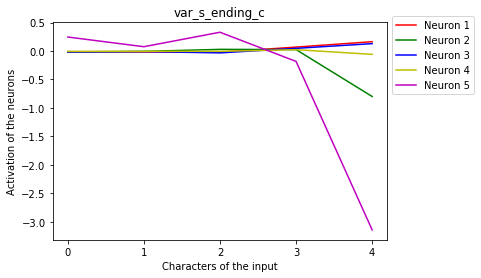

In [527]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')
temp = var_s_ending_c - var_c

for i in range(latent_dim):
    plt.plot(range(5), temp[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('var_s_ending_c')
plt.legend(bbox_to_anchor=(1.275, 1.05))

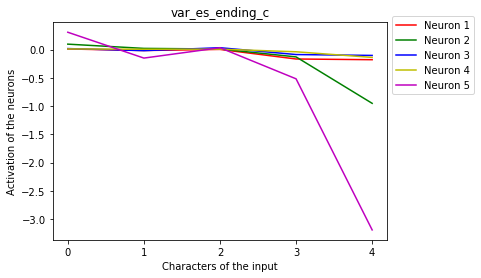

In [528]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')
temp = var_es_ending_c - var_c
for i in range(latent_dim):
    plt.plot(range(5), temp[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('var_es_ending_c')
plt.legend(bbox_to_anchor=(1.275, 1.05))

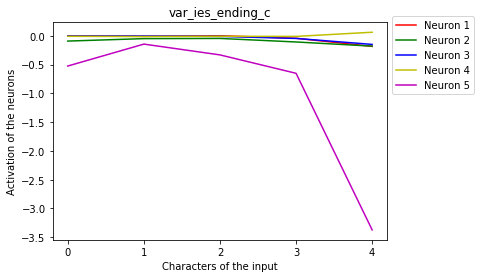

In [529]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')
temp = var_ies_ending_c - var_c
for i in range(latent_dim):
    plt.plot(range(5), temp[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('var_ies_ending_c')
plt.legend(bbox_to_anchor=(1.275, 1.05))

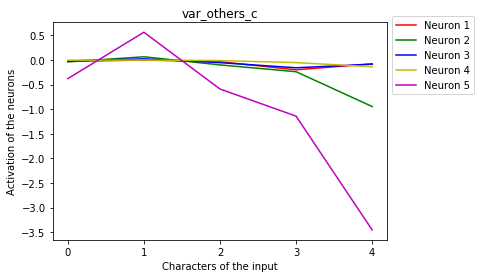

In [530]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')
temp = var_others_c - var_c
for i in range(latent_dim):
    plt.plot(range(5), temp[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('var_others_c')
plt.legend(bbox_to_anchor=(1.275, 1.05))

# Mean of hidden states

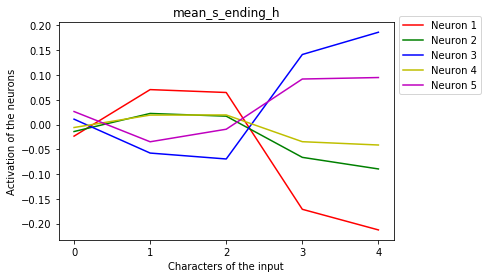

In [532]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')
temp = mean_s_ending_h - mean_h
for i in range(latent_dim):
    plt.plot(range(5), temp[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('mean_s_ending_h')
plt.legend(bbox_to_anchor=(1.275, 1.05))

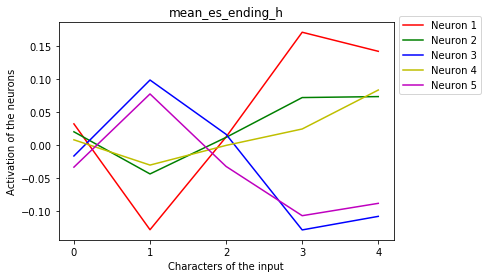

In [533]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')
temp = mean_es_ending_h - mean_h

for i in range(latent_dim):
    plt.plot(range(5), temp[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('mean_es_ending_h')
plt.legend(bbox_to_anchor=(1.275, 1.05))

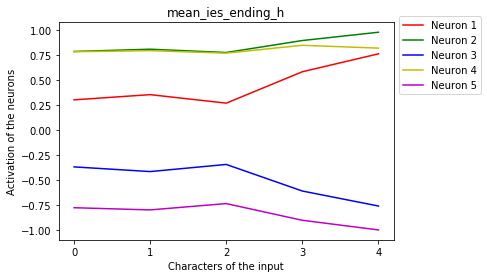

In [507]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')

for i in range(latent_dim):
    plt.plot(range(5), mean_ies_ending_h[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('mean_ies_ending_h')
plt.legend(bbox_to_anchor=(1.275, 1.05))

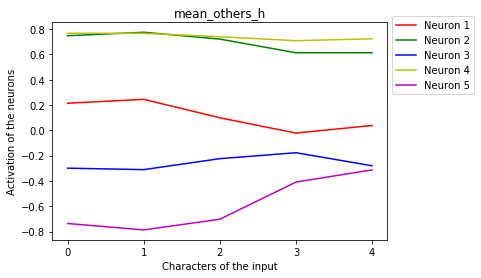

In [508]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')

for i in range(latent_dim):
    plt.plot(range(5), mean_others_h[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('mean_others_h')
plt.legend(bbox_to_anchor=(1.275, 1.05))

# Variance of hidden state

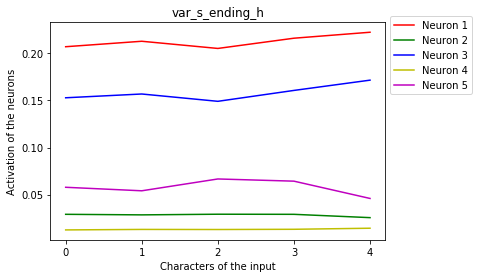

In [509]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')

for i in range(latent_dim):
    plt.plot(range(5), var_s_ending_h[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('var_s_ending_h')
plt.legend(bbox_to_anchor=(1.275, 1.05))

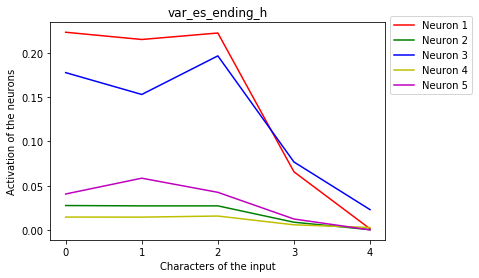

In [510]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')

for i in range(latent_dim):
    plt.plot(range(5), var_es_ending_h[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('var_es_ending_h')
plt.legend(bbox_to_anchor=(1.275, 1.05))

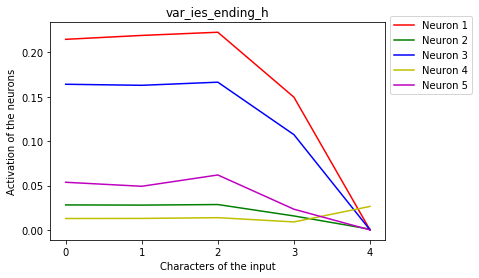

In [511]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')

for i in range(latent_dim):
    plt.plot(range(5), var_ies_ending_h[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('var_ies_ending_h')
plt.legend(bbox_to_anchor=(1.275, 1.05))

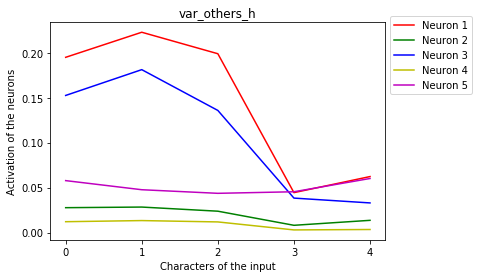

In [512]:
colors = ['r', 'g', 'b', 'y', 'm']
characters = [word[i] for i in range(len(word))]
plt.xticks(range(len(word)))
plt.xlabel('Characters of the input')
plt.ylabel('Activation of the neurons')

for i in range(latent_dim):
    plt.plot(range(5), var_others_h[i, :], colors[i], label='Neuron '+ str(i+1))
plt.title('var_others_h')
plt.legend(bbox_to_anchor=(1.275, 1.05))

In [534]:
mean_c

array([[ 0.41475132,  0.40387657,  0.43212268,  0.68376422,  0.8159678 ],
       [ 1.36984348,  1.36990571,  1.37990212,  1.65035176,  2.47262168],
       [-0.4835563 , -0.48398075, -0.49593815, -0.72199106, -0.83791935],
       [ 1.13602555,  1.12908161,  1.13045812,  1.23081839,  1.38662159],
       [-1.73721576, -1.65636408, -1.62399125, -2.18195915, -3.92730379]], dtype=float32)

In [542]:
out

51